In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model

In [4]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'data/validate',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 3219 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


In [5]:
# Load pre-trained MobileNetV2 model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

C:\Users\Evan Mazor\AppData\Local\Temp\ipykernel_136\568885867.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


In [6]:

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Class weights to handle imbalance
class_weights = {0: 1.0, 1: 14.1236842105}

# # Train the model
hist = model.fit(train_generator, epochs=10, validation_data=validation_generator, class_weight=class_weights)

Epoch 1/10


c:\Users\Evan Mazor\code\repos\bite-recognition\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8895 - loss: 2.5583 - val_accuracy: 0.9360 - val_loss: 0.1954
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9490 - loss: 0.2214 - val_accuracy: 0.9651 - val_loss: 0.0758
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9615 - loss: 0.1555 - val_accuracy: 0.9826 - val_loss: 0.0658
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9730 - loss: 0.1054 - val_accuracy: 0.9360 - val_loss: 0.1692
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9628 - loss: 0.1870 - val_accuracy: 0.9709 - val_loss: 0.0710
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9808 - loss: 0.0946 - val_accuracy: 0.9709 - val_loss: 0.0927
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9809 - loss: 0.0723 - val_accuracy: 0.9593 - val_loss: 0.0945
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9876 - loss: 0.0670 - val_accuracy: 0.965

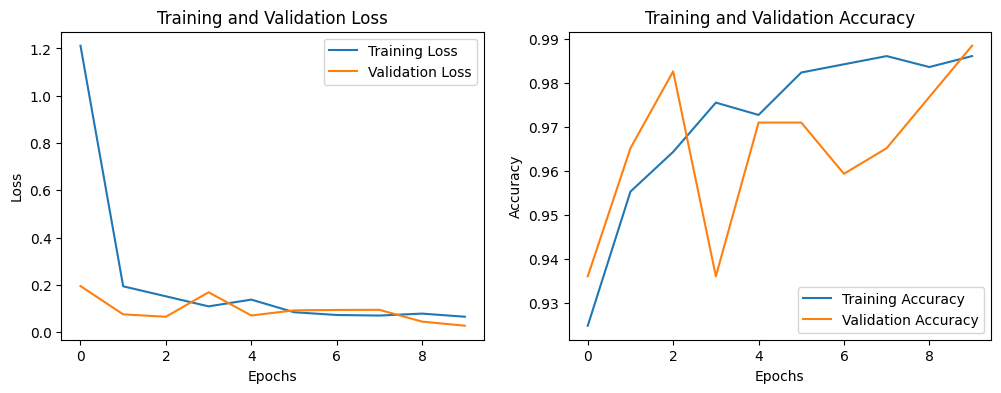

In [14]:
import matplotlib.pyplot as plt

# Extracting data from the history object
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
training_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
model.save('training3.h5')

In [18]:
# model = load_model('training1.h5')  # accuracy: 0.9834 - loss: 0.0587
# model = load_model('training2.h5')  # accuracy: 0.9747 - loss: 0.1484
model = load_model('training3.h5')  # accuracy: 0.9875 - loss: 0.0495

# Evaluate the model
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

model.evaluate(test_generator)

Found 862 images belonging to 2 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 948ms/step - accuracy: 0.9875 - loss: 0.0495


[0.04365720972418785, 0.988399088382721]